In [1]:
import sys
from pathlib import Path

# Add the parent directory to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

In [2]:
import numpy as np
import torch
from scipy import signal
import obspy.io.segy.core as op
from models import *
from denoisers.dip import losses, schedules, SGDIP
from utils.das import *

In [3]:
file = '../data/das/FORGE/FORGE_78-32_iDASv3-P11_UTC190428070308.sgy'
stream = op._read_segy(file, format='segy')
noisy = np.vstack([trace.data for trace in stream])

noisy = noisy[200:960 + 200, 19500:21500]
noisy = signal.resample(noisy, 1000, axis=1)

noisy /= noisy.std()

In [6]:
pre_processed = lowpass(noisy, 200, 1000)
pre_processed = substract_median(pre_processed)
pre_processed, local_std = normalize(pre_processed)

y = torch.Tensor(pre_processed.copy()).unsqueeze(0).unsqueeze(0)

In [8]:
net = UNetECA(in_ch=1, out_ch=1)
schedule = schedules.Linear(1, 10)
loss = losses.Compose(losses.MSE(), losses.AE(), schedule)
sgdip = SGDIP(net, loss, max_epochs=300, ratio=0.5)

Running: 0 - SGDIP (k=3, r=0.5, ref=False) - MSE + AE (alpha=Linear (1, 10)) - UNet ECA 


100%|██████████| 300/300 [01:35<00:00,  3.13it/s]


Summary: {'runtime': '00:01:37'}



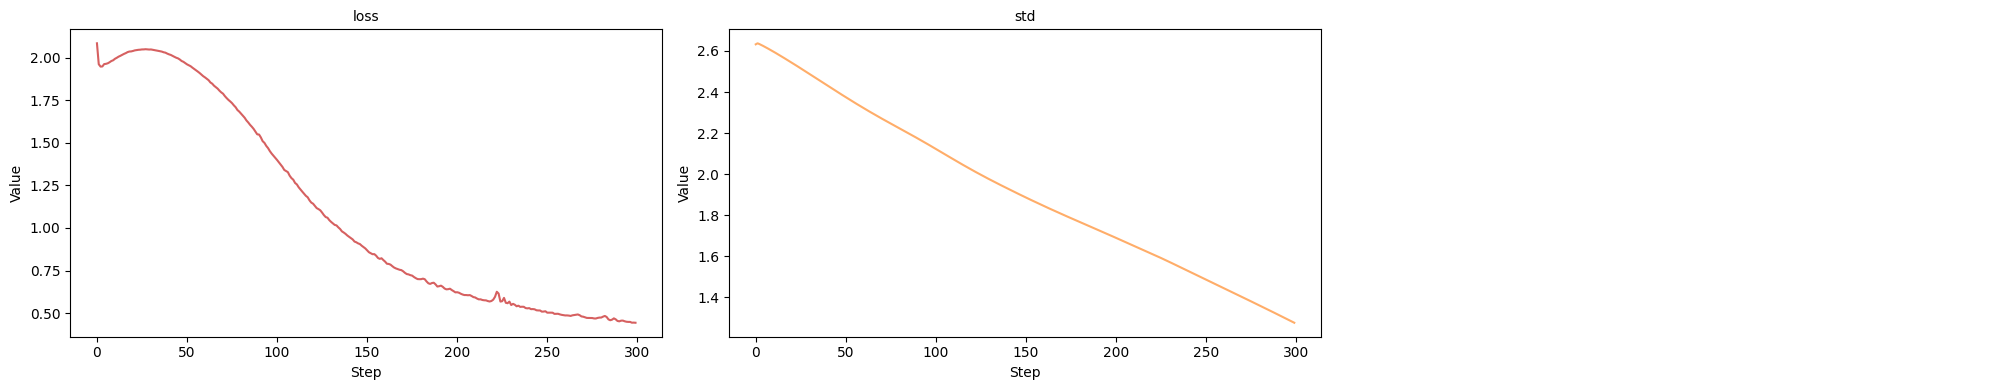

In [9]:
x_hat, _, _ = sgdip.denoise(y)
x_hat = x_hat.detach().clone().cpu()

In [10]:
denoised = x_hat.squeeze().numpy()
denoised = denoised * local_std

diff = noisy - denoised

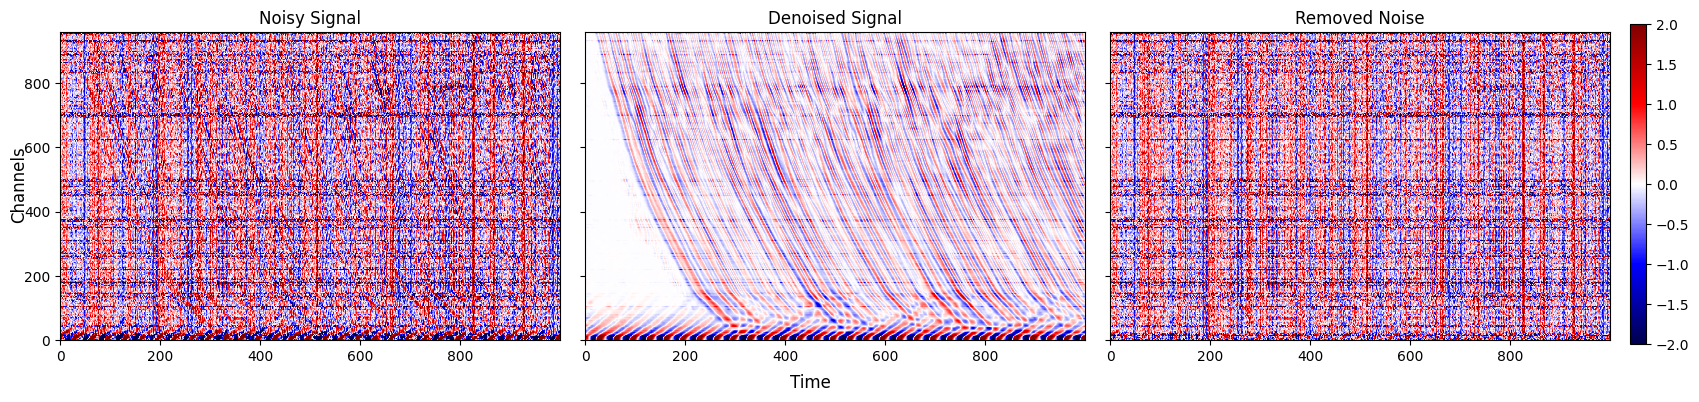

In [11]:
clip = 2

fig, axes = plt.subplots(1, 3, figsize=(20, 4), sharex=True, sharey=True)

im1 = axes[0].imshow(noisy, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[0].set_title('Noisy Signal')

axes[1].imshow(denoised, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[1].set_title('Denoised Signal')

axes[2].imshow(diff, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[2].set_title('Removed Noise')

fig.supxlabel('Time', y=-0.02)
fig.supylabel('Channels', x=0.1)

cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.01)
cbar.ax.set_position([0.91, 0.1, 0.2, 0.8])

plt.subplots_adjust(wspace=0.05)
plt.show()